### Imports

In [1]:
import glob
from PIL import Image
import os
import keras
import tensorflow as tf
import keras.utils
from keras.preprocessing import image
from keras import utils as np_util0s
import threading
from numpy import random
from bs4 import BeautifulSoup
import scipy
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy.misc import imresize
from keras.layers import Input
from tiramisu import *
import datetime
from time import time
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Input

%matplotlib inline

Using TensorFlow backend.


In [2]:
session_config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)    
# please do not use the totality of the GPU memory
session_config.gpu_options.per_process_gpu_memory_fraction = 0.90

### Load data

This data has been already preprocessed i.e. normalized and standardized.

In [5]:
training_imgs = np.load('/media/narita/Data/Neutrophils/train_test_images/train_validation_combined/npys/images/training_imgs_224x224.npy')
training_labels = np.load('/media/narita/Data/Neutrophils/train_test_images/train_validation_combined/npys/converted_labels/training_labels_with_borders_int_224x224.npy')


testing_imgs = np.load('/media/narita/Data/Neutrophils/train_test_images/testing_npys/images/testing_imgs_224x224.npy')
testing_labels = np.load('/media/narita/Data/Neutrophils/train_test_images/testing_npys/converted_npys/testing_labels_with_borders_int_224x224.npy')



In [6]:
print (training_imgs.shape,training_labels.shape)

((366, 224, 224, 3), (366, 224, 224))


In [7]:
print (testing_imgs.shape,testing_labels.shape)

((46, 224, 224, 3), (46, 224, 224))


In [8]:
'''
# Settings for img_size 1024x1024
mu = 0.40652763802991992
std = 0.10811594310979132
'''

'''
# Settings for img_size 224x224
mu = 0.40651816005481112
std = 0.10812693486000097
'''
# Without7
mu = 0.42405027826818381
std = 0.10426620392610358

### Initialize ShuffleSplit

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
ss = ShuffleSplit(n_splits=3, test_size=0.1,random_state=0)

In [ ]:
 ss

### Generators

In [13]:
# Batch Generator
class BatchIndices(object):
    """
    Generates batches of shuffled indices.
    # Arguments
        n: number of indices
        bs: batch size
        shuffle: whether to shuffle indices, default True 
    
    """
    def __init__(self, n, bs, shuffle=True):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [14]:
# Segmentor

from keras.utils import to_categorical
class segm_generator(object):
    """
    Generates batches of sub-images.
    # Arguments
        x: array of inputs
        y: array of targets
        bs: batch size
        out_sz: dimension of sub-image
        train: If true, will shuffle/randomize sub-images
        waldo: If true, allow sub-images to contain targets.
    """
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n = x.shape[0]
        self.ri, self.ci = [], []
        for i in range(self.n):
            ri, ci, _ = x[i].shape
            self.ri.append(ri), self.ci.append(ci) 
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1
        
    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        #slice_r = self.get_slice(self.ri[idx], self.ro)
        #slice_c = self.get_slice(self.ci[idx], self.co)
        x = self.x[idx]
        #[slice_r, slice_c]
        y = self.y[idx]
        #[slice_r, slice_c]

        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, to_categorical(y, num_classes=3)

    def __next__(self):
        idxs = self.idx_gen.__next__()
        items = []
        for idx in idxs:
            item = self.get_item(idx)
            if item is not None:
                items.append(item)
        if not items:
            return None
        xs,ys = zip(*tuple(items))
        return np.stack(xs), np.stack(ys)

In [15]:
# For Python 2 compatibility

def seg_gen(x, y, bs=64, out_sz=(224,224), train=True):
    """
    Generator wrapper on iterators for python 2 compatibility.
    """
    sg = segm_generator(x=x, y=y, bs=bs, out_sz = out_sz ,train=train)
    while True:
        yield sg.__next__()

### View samples

In [16]:
gen = seg_gen(training_imgs, training_labels, bs=4, train=True)

In [17]:
X, y = next(gen)

In [18]:
y.shape


(4, 50176, 3)

/home/narita/.local/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


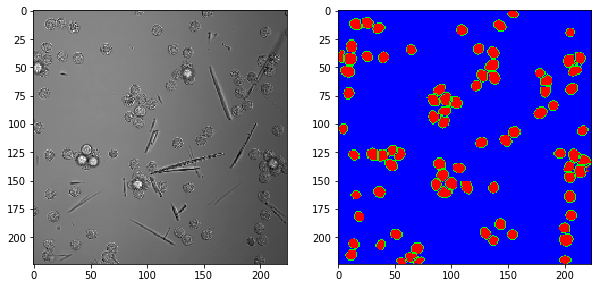

In [19]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 10))

gs = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


ax1.imshow(X[0]*std+mu)
ax2.imshow((y[0].reshape(224,224,3)), cmap='spectral',interpolation='nearest')

plt.show()

### Calculate class weights

In [20]:
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        if (key == 2):
                score = 1./float(labels_dict[key])
                class_weight[key] = score
        else:
            #score = 1./float(labels_dict[key])
            score = (1 - (float(labels_dict[key])/total))
            class_weight[key] = score
    return class_weight


In [21]:
training_labels.shape

(366, 224, 224)

In [22]:
#We're going to count the class frequency across the original labels. One common approach to correcting class imbalance is inverse frequency weighting.
freq0 = float(np.sum(training_labels==0))

freq1 = float(np.sum(training_labels==1))

freq2 = float(np.sum(training_labels==2))


In [23]:
print (freq0,freq1,freq2)


(1298332.0, 474057.0, 16592027.0)


In [24]:
# random labels_dict
labels_dict = {0: freq0, 1: freq1, 2: freq2}


In [25]:
class_weights =create_class_weight(labels_dict)
class_weights

{0: 0.92930175400078063, 1: 0.97418611079165274, 2: 6.026991156656146e-08}

In [26]:
#class_weights = {0: 0.88344237959800853, 1: 0.90531131492415517, 2: 6.792343127439301e-08}

sample_weights = np.zeros((X.shape[0], X.shape[1] * X.shape[2], 3))

sample_weights[:,:,0] = class_weights[0]

sample_weights[:,:,1] = class_weights[1]

sample_weights[:,:,2] = class_weights[2]

In [27]:
class_weights

{0: 0.92930175400078063, 1: 0.97418611079165274, 2: 6.026991156656146e-08}

In [28]:
class_weights = {0: 0.92930175400078063, 1: 0.97418611079165274, 2: 6.026991156656146e-08}


### Build Model

#### Train on 224x224 whole image

In [29]:
from keras.models import load_model

def create_model(input_shape):
    img_input = Input(shape=input_shape)
    x = create_tiramisu(3, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)
    model = Model(img_input, x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"], sample_weight_mode='temporal')
    
    return model

In [30]:
def create_train_generator(imgs,labels,bs=2):
    return seg_gen(imgs, labels, bs=bs, train=True) 

In [31]:
def create_test_generator(imgs,labels,bs=2):
    return seg_gen(imgs, labels, bs=2, train=False)

In [35]:
def train_and_evaluate_model(model,current_fold,gen_train,gen_test,sample_weights,ckpt_dir,log_dir,epochs=100):
    
    z = datetime.datetime.now().strftime ("%Y%m%d")
    ckpt_file_name = ckpt_dir +"/"+ z +"_fold"+ current_fold +".hdf5"
    checkpoint = ModelCheckpoint(ckpt_file_name, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    tensorboard = TensorBoard(log_dir=log_dir+"/{}".format(time()))
    callbacks_list = [checkpoint,tensorboard]


    model.fit_generator(
                        gen_train,steps_per_epoch=183,verbose=2,epochs=epochs,
                        validation_data=gen_test, validation_steps=23,
                        class_weight=sample_weights,callbacks=callbacks_list
                    )
    return model

#### Create crossval dictionaries
Since OOM is constantly troubling let's save those folds to a file. 

##### Create folds and store them

In [ ]:
import pickle

X_train = dict()
X_val = dict()
y_train = dict()
y_val = dict()
current_fold = 0
for train_index, val_index in ss.split(training_imgs):
    print "Running Fold:", current_fold+1, "/", 3
    X_train[current_fold]=train_index
    X_val[current_fold]=val_index
    y_train[current_fold]=train_index
    y_val[current_fold]=val_index
    current_fold +=1                 
        

f1 = "/media/narita/Data/Neutrophils/npys/trained_models/with_borders_with_class_weighing/whole_image_224x224/crossval_folds/X_train"
with open(f1+ '.pkl', 'wb') as f:
    pickle.dump(X_train, f, pickle.HIGHEST_PROTOCOL)


f2 = "/media/narita/Data/Neutrophils/npys/trained_models/with_borders_with_class_weighing/whole_image_224x224/crossval_folds/X_val"
with open(f2+ '.pkl', 'wb') as f:
    pickle.dump(X_val, f, pickle.HIGHEST_PROTOCOL)

f3 = "/media/narita/Data/Neutrophils/npys/trained_models/with_borders_with_class_weighing/whole_image_224x224/crossval_folds/y_train"
with open(f3+ '.pkl', 'wb') as f:
    pickle.dump(y_train, f, pickle.HIGHEST_PROTOCOL)

f4 = "/media/narita/Data/Neutrophils/npys/trained_models/with_borders_with_class_weighing/whole_image_224x224/crossval_folds/y_val"
with open(f4+ '.pkl', 'wb') as f:
    pickle.dump(y_val, f, pickle.HIGHEST_PROTOCOL)


#### Read a particular fold 

In [ ]:
import pickle

f1 = "/media/narita/Data/Neutrophils/npys/trained_models/with_borders_with_class_weighing/whole_image_224x224/crossval_folds/X_train.pkl"
with open(f1, 'rb') as f:
    X_train = pickle.load(f)

f2 = "/media/narita/Data/Neutrophils/npys/trained_models/with_borders_with_class_weighing/whole_image_224x224/crossval_folds/X_val.pkl"
with open(f2, 'rb') as f:
    X_val = pickle.load(f)

f3 = "/media/narita/Data/Neutrophils/npys/trained_models/with_borders_with_class_weighing/whole_image_224x224/crossval_folds/y_train.pkl"
with open(f3, 'rb') as f:
    y_train = pickle.load(f)

f4 = "/media/narita/Data/Neutrophils/npys/trained_models/with_borders_with_class_weighing/whole_image_224x224/crossval_folds/y_val.pkl"
with open(f4, 'rb') as f:
    y_val = pickle.load(f)



In [ ]:
current_fold = 2
Xt, Xv = X_train[current_fold], X_val[current_fold]
yt, yv = y_train[current_fold], y_val[current_fold]

In [ ]:
print (len(Xt),len(yt))
print (len(Xv),len(yv))

In [ ]:
train_imgs, train_labels = training_imgs[Xt], training_labels[yt]
val_imgs, val_labels = training_imgs[Xv], training_labels[yv]

In [ ]:
val_imgs.shape

#### Train

In [33]:
current_fold = '4'
current_fold

'4'

In [36]:

input_shape = (224,224,3)

model = None
model = create_model(input_shape)
gen_train = create_train_generator(training_imgs,training_labels)
gen_test = create_test_generator(testing_imgs,testing_labels)
ckpt_dir = "/media/narita/Data/Neutrophils/segmentation_results/trained_models/with_borders_with_class_weighing/whole_image_224x224_2"
log_dir = "/media/narita/Data/Neutrophils/segmentation_results/trained_models/with_borders_with_class_weighing/whole_image_224x224_2/logs"
train_and_evaluate_model(
                            model,str(current_fold),gen_train, gen_test,
                            sample_weights, ckpt_dir, log_dir

                        )

    

Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.91490, saving model to /media/narita/Data/Neutrophils/segmentation_results/trained_models/with_borders_with_class_weighing/whole_image_224x224_2/20170918_fold4.hdf5
120s - loss: 0.5822 - acc: 0.9005 - val_loss: 0.2733 - val_acc: 0.9149
Epoch 2/100
Epoch 00001: val_acc improved from 0.91490 to 0.95256, saving model to /media/narita/Data/Neutrophils/segmentation_results/trained_models/with_borders_with_class_weighing/whole_image_224x224_2/20170918_fold4.hdf5
89s - loss: 0.2551 - acc: 0.9299 - val_loss: 0.1788 - val_acc: 0.9526
Epoch 3/100
Epoch 00002: val_acc did not improve
87s - loss: 0.2107 - acc: 0.9390 - val_loss: 0.1745 - val_acc: 0.9497
Epoch 4/100
Epoch 00003: val_acc did not improve
84s - loss: 0.1804 - acc: 0.9466 - val_loss: 0.1811 - val_acc: 0.9382
Epoch 5/100
Epoch 00004: val_acc improved from 0.95256 to 0.95336, saving model to /media/narita/Data/Neutrophils/segmentation_results/trained_models/with_borders_with_class_

Epoch 00051: val_acc did not improve
87s - loss: 0.0954 - acc: 0.9670 - val_loss: 0.1005 - val_acc: 0.9628
Epoch 53/100
Epoch 00052: val_acc did not improve
87s - loss: 0.0948 - acc: 0.9672 - val_loss: 0.0988 - val_acc: 0.9651
Epoch 54/100
Epoch 00053: val_acc did not improve
87s - loss: 0.0954 - acc: 0.9671 - val_loss: 0.1007 - val_acc: 0.9646
Epoch 55/100
Epoch 00054: val_acc did not improve
84s - loss: 0.0949 - acc: 0.9672 - val_loss: 0.1006 - val_acc: 0.9647
Epoch 56/100
Epoch 00055: val_acc did not improve
84s - loss: 0.0947 - acc: 0.9672 - val_loss: 0.1224 - val_acc: 0.9571
Epoch 57/100
Epoch 00056: val_acc did not improve
84s - loss: 0.0950 - acc: 0.9672 - val_loss: 0.0980 - val_acc: 0.9646
Epoch 58/100
Epoch 00057: val_acc did not improve
85s - loss: 0.0940 - acc: 0.9673 - val_loss: 0.1295 - val_acc: 0.9547
Epoch 59/100
Epoch 00058: val_acc did not improve
85s - loss: 0.0942 - acc: 0.9672 - val_loss: 0.1037 - val_acc: 0.9625
Epoch 60/100
Epoch 00059: val_acc did not improve
86s

In [37]:
print ('Training Done..')

Training Done..


#### Trials

In [ ]:
model.fit_generator(gen_train,steps_per_epoch=5,verbose=2,epochs=100,validation_data=gen_test, validation_steps=5,class_weight=sample_weights,callbacks=callbacks_list)

In [ ]:

model.optimizer=keras.optimizers.RMSprop(2e-5, decay=1-0.9995)

In [ ]:
z = datetime.datetime.now().strftime ("%Y%m%d")
ckpt_file_name = ckpt_dir +"/"+ z +"_fold"+ current_fold +".hdf5"
checkpoint = ModelCheckpoint(ckpt_file_name, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
tensorboard = TensorBoard(log_dir=log_dir+"/{}".format(time()))
callbacks_list = [checkpoint,tensorboard]


model.fit_generator(
                    gen_train,steps_per_epoch=215,verbose=2,epochs=50,
                    validation_data=gen_test, validation_steps=23,
                    class_weight=sample_weights,callbacks=callbacks_list
                )

In [ ]:
model.optimizer=keras.optimizers.RMSprop(3e-5, decay=1-0.9995)

In [ ]:
model.fit_generator(gen_train,steps_per_epoch=5,verbose=2,epochs=50,validation_data=gen_test, validation_steps=5,class_weight=sample_weights,callbacks=callbacks_list)

### Predict on all test data

In [38]:
input_shape = (224,224,3)

model = None
model = create_model(input_shape)
#gen_train = create_train_generator(train_imgs,train_labels)
#gen_test = create_test_generator(val_imgs,val_labels)


In [39]:
# Since the model showed smooth performance on fold2. Let's load it
# and use it for prediction on test data
gen_test = create_test_generator(testing_imgs, testing_labels)
model_path = '/media/narita/Data/Neutrophils/segmentation_results/trained_models/with_borders_with_class_weighing/whole_image_224x224_2/20170918_fold4.hdf5'
#model_path = '/media/narita/Data/Neutrophils/segmentation_npys/trained_models/with_borders_with_class_weighing/whole_image_224x224/20170905_fold4.hdf5'

model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"], sample_weight_mode='temporal')
model.load_weights(model_path)


In [40]:
model.evaluate_generator(gen_test,steps=23, max_queue_size=10, workers=1, use_multiprocessing=False)

[0.098008310989193298, 0.96567437182302063]

In [41]:
model.metrics_names

['loss', 'acc']

### Predict on all test data

In [42]:
def predict(img,model):
    predicted_img= model.predict(img)
    return img, predicted_img


In [43]:
model_path = '/media/narita/Data/Neutrophils/segmentation_results/trained_models/with_borders_with_class_weighing/whole_image_224x224_2/20170918_fold4.hdf5'
#model_path = '/media/narita/Data/Neutrophils/segmentation_npys/trained_models/with_borders_with_class_weighing/whole_image_224x224/20170905_fold4.hdf5'
model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"], sample_weight_mode='temporal')

model.load_weights(model_path)


out_path = '/media/narita/Data/Neutrophils/train_test_images/testing_npys/segmentation_output/whole_img_resized_224x224'
for i, full_img in enumerate(testing_imgs):
    full_img_r, full_pred = predict(np.array([full_img]),model)
    np.save(os.path.join(out_path,str(i)),full_pred)
    print ('Processed:'+str(i)+" / "+str(len(testing_imgs)))

Processed:0 / 46
Processed:1 / 46
Processed:2 / 46
Processed:3 / 46
Processed:4 / 46
Processed:5 / 46
Processed:6 / 46
Processed:7 / 46
Processed:8 / 46
Processed:9 / 46
Processed:10 / 46
Processed:11 / 46
Processed:12 / 46
Processed:13 / 46
Processed:14 / 46
Processed:15 / 46
Processed:16 / 46
Processed:17 / 46
Processed:18 / 46
Processed:19 / 46
Processed:20 / 46
Processed:21 / 46
Processed:22 / 46
Processed:23 / 46
Processed:24 / 46
Processed:25 / 46
Processed:26 / 46
Processed:27 / 46
Processed:28 / 46
Processed:29 / 46
Processed:30 / 46
Processed:31 / 46
Processed:32 / 46
Processed:33 / 46
Processed:34 / 46
Processed:35 / 46
Processed:36 / 46
Processed:37 / 46
Processed:38 / 46
Processed:39 / 46
Processed:40 / 46
Processed:41 / 46
Processed:42 / 46
Processed:43 / 46
Processed:44 / 46
Processed:45 / 46


#### Let's see some predictions

In [48]:
preds=np.load('/media/narita/Data/Neutrophils/train_test_images/testing_npys/segmentation_output/whole_img_resized_224x224/15.npy')

In [49]:
preds1 = preds.copy()
preds1 = preds1.reshape(224,224,3)
preds1.shape

(224, 224, 3)

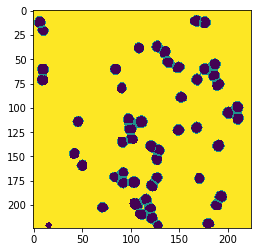

In [50]:

preds1_copy = np.argmax(preds, axis=-1)
preds1_copy = preds1_copy.reshape(224,224)
plt.imshow(preds1_copy)

In [51]:
preds1_copy

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ..., 
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

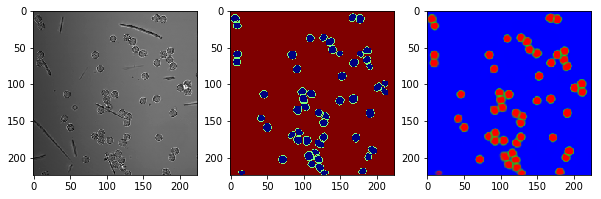

In [47]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 10))

gs = gridspec.GridSpec(1, 3)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1.imshow(testing_imgs[15]*std+mu)
ax2.imshow((testing_labels[15]), cmap='jet',interpolation='nearest')
ax3.imshow((preds1), cmap='jet',interpolation='nearest')

plt.show()

In [ ]:
testing_labels[15]

In [54]:
temp2 = (preds1_copy)
new_array2 = [tuple(row) for row in temp2]
uniques2 = np.unique(new_array2)
print ((uniques2))

[0 1 2]


In [ ]:
print uniques2[0:100]

In [ ]:
ZZ = Image.fromarray((preds1*255).astype('uint8'))
ZZ
